In [6]:
# importing required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import ticker as ticker

# define matplotlib style
plt.style.use("ggplot")

def round_to_ndigits(i,n):
    return float('{:g}'.format(float('{:.{p}g}'.format(i, p=n))))

round_num = np.vectorize(lambda x: round_to_ndigits(x, 3))#, otypes=np.float)



In [7]:
# headers for each column
roundtripTime_header = "Roundtrip Time (s)"
payloadSize_header = "Payload Size (bytes)"

arrivalTime_header = "Arrival Time (s)"

physicalLayer_header = "Physical Layer"
distance_header = "Distance (cm)"
mtu_header = "ATT Maximum Transmission Unit (bytes)"
adapter_header = "Adapter"

characteristicHandler_header = 'Characteristic Handler Value'
expectedTimeBetweenPackets_header = 'Time between packets (ms)'
observedTimeBetweenPackets_header = 'Observed Time between packets (ms)'
observedTimeStdBetweenPackets_header = 'Observed Time Std between packets (ms)'
packetLoss_header = 'Packet Loss (%)'
firstPayloadSize_header = "First Payload Size (bytes)"
maxPayloadSize_header = "Max Payload Size (bytes)"   

payloadSizeDiff_header = "Payload Size Diff (bytes)"
averageRoundtripTime_header = "Average Roundtrip Time (s)"
stdRoundtripTime_header = "Standard Dev Roundtrip Time"

# 3s run time for bandwidth tests
bandwidth_runtime = 3

bandwidthTestRunIndex_header = 'Run Index'

#phyTypes = ["LE1M", "LE2M"]
#distances = [0, 300, 600, 900, 1200, 1500]
#tests = ["roundtrip", "bandwidth"]
#mtuTypes = [23, 251]
#adapters = ["hci0", "hci1"]

phyTypes = ["LE1M"]
distances = [0, 300, 600, 900]
tests = ["roundtrip", "bandwidth1", "bandwidth2", "bandwidth3"]
mtuTypes = [23, 251]
adapters = ["hci0", "hci1"]

roundtrip_tests = pd.DataFrame(columns=[roundtripTime_header, payloadSize_header, adapter_header, physicalLayer_header, distance_header, mtu_header], dtype=None)
roundtrip_tests[roundtripTime_header] = roundtrip_tests[roundtripTime_header].astype(np.float)
roundtrip_tests[payloadSize_header] = roundtrip_tests[payloadSize_header].astype(np.int)
roundtrip_tests[adapter_header] = roundtrip_tests[adapter_header].astype("string")
roundtrip_tests[physicalLayer_header] = roundtrip_tests[physicalLayer_header].astype("string")
roundtrip_tests[distance_header] = roundtrip_tests[distance_header].astype(np.int)
roundtrip_tests[mtu_header] = roundtrip_tests[mtu_header].astype(np.int)

bandwidth_tests = pd.DataFrame(columns=[bandwidthTestRunIndex_header, arrivalTime_header, payloadSize_header, expectedTimeBetweenPackets_header, adapter_header, physicalLayer_header, distance_header, mtu_header])
bandwidth_tests[bandwidthTestRunIndex_header] = bandwidth_tests[bandwidthTestRunIndex_header].astype(np.int)
bandwidth_tests[arrivalTime_header] = bandwidth_tests[arrivalTime_header].astype(np.float)
bandwidth_tests[expectedTimeBetweenPackets_header] = bandwidth_tests[expectedTimeBetweenPackets_header].astype(np.float)
bandwidth_tests[payloadSize_header] = bandwidth_tests[payloadSize_header].astype(np.int)
bandwidth_tests[adapter_header] = bandwidth_tests[adapter_header].astype("string")
bandwidth_tests[physicalLayer_header] = bandwidth_tests[physicalLayer_header].astype("string")
bandwidth_tests[distance_header] = bandwidth_tests[distance_header].astype(np.int)
bandwidth_tests[mtu_header] = bandwidth_tests[mtu_header].astype(np.int)

bandwidthtest_results= pd.DataFrame(columns=[bandwidthTestRunIndex_header, observedTimeBetweenPackets_header, payloadSize_header, expectedTimeBetweenPackets_header, adapter_header, distance_header, packetLoss_header])

for test in tests:
    for adapter in adapters:
        for distance in distances:
            for phy in phyTypes:
                for mtu in mtuTypes:
                    if test == "roundtrip":
                        fileName = "roundtrip/{}-{}_results_at_{}cm{}_MTU{}.csv".format(adapter, test, distance, phy, mtu)
                    elif ("bandwidth" in test):
                        fileName = "bandwidth/{}-{}_results_at_{}cm{}_MTU{}.csv".format(adapter, test, distance, phy, mtu)
                    else:
                        print('what')
                        exit(1)

                    # importing data 
                    raw_data = None

                    try:
                        raw_data = pd.read_csv(fileName)
                    except:
                        print("{} not found.".format(fileName))
                        continue # skip the rest of the code

                    raw_data[adapter_header] = adapter
                    raw_data[physicalLayer_header] = phy
                    raw_data[distance_header] = distance
                    raw_data[mtu_header] = mtu
                    
                    raw_data = raw_data.convert_dtypes()
                    if test == "roundtrip":
                        data = raw_data.iloc[0:0,:].copy()
                        payloadSizes = raw_data[payloadSize_header].unique()

                        # get average roundtrip time for each payload
                        for payload in payloadSizes:
                            payloadData = raw_data[(raw_data[payloadSize_header] == payload)]
                            data = data.append(payloadData[(payloadData[roundtripTime_header] > payloadData[roundtripTime_header].quantile(0.20)) & (payloadData[roundtripTime_header] < payloadData[roundtripTime_header].quantile(0.80))].mean(numeric_only=True), ignore_index=True)
                            #print(payloadData[(payloadData[roundtripTime_header] > payloadData[roundtripTime_header].#quantile(0.20)) & 
                            #(payloadData[roundtripTime_header] < payloadData[roundtripTime_header].quantile(0.80))])
                            
                        data[physicalLayer_header] = phy
                        data[adapter_header] = adapter
                        roundtrip_tests = roundtrip_tests.append(data.astype(roundtrip_tests.dtypes), ignore_index=True)
                    elif ("bandwidth" in test):
                        testRunIndex = int(test[-1])
                        # TODO: process bandwidth data tests
                        raw_data[bandwidthTestRunIndex_header] = testRunIndex
                        raw_data[physicalLayer_header] = phy
                        raw_data[adapter_header] = adapter
                        data = raw_data.convert_dtypes()
                        bandwidth_tests = bandwidth_tests.append(data, ignore_index=True)

                        payloadSize = data[payloadSize_header].mean()
                        characteristicHandlers = data[characteristicHandler_header].unique()
                        allTimesBetweenPackets = data[expectedTimeBetweenPackets_header].unique()
                        
                        # calculate average time diff for each characteristicHandlers for each expectedTime
                        for timeBetweenPackets in allTimesBetweenPackets:
                            tempResultsForTime = pd.DataFrame()
                            
                            for characteristicHandler in characteristicHandlers:
                                vals = data[(data[characteristicHandler_header]==characteristicHandler) & (data[expectedTimeBetweenPackets_header]==timeBetweenPackets)]
                                #print((((len(vals[arrivalTime_header]) - 1) * timeBetweenPackets ) / ((vals[arrivalTime_header].max()-vals[arrivalTime_header].min())*1000)))
                                packetLoss = 1 - (((vals[arrivalTime_header]).size)-0.5)* timeBetweenPackets / ((vals[arrivalTime_header].max()-vals[arrivalTime_header].min())*1000)

                                tempData = {
                                    observedTimeBetweenPackets_header: vals[arrivalTime_header].diff().mean()*1000,
                                    observedTimeStdBetweenPackets_header: vals[arrivalTime_header].diff().std()*1000, 
                                    characteristicHandler_header: characteristicHandler,
                                    packetLoss_header: 100*(1 if packetLoss > 1 else 0 if packetLoss < 0 else packetLoss)
                                    }

                                tempResultsForTime = tempResultsForTime.append(tempData, ignore_index = True)
                            
                            #print(tempResultsForTime[packetLoss_header])
                            tempData = {
                                    adapter_header : adapter,
                                    distance_header : distance,
                                    bandwidthTestRunIndex_header : testRunIndex,
                                    observedTimeBetweenPackets_header: tempResultsForTime[observedTimeBetweenPackets_header].mean(), 
                                    observedTimeStdBetweenPackets_header: tempResultsForTime[observedTimeBetweenPackets_header].std(), 
                                    expectedTimeBetweenPackets_header: timeBetweenPackets,
                                    payloadSize_header: payloadSize,
                                    packetLoss_header: tempResultsForTime[packetLoss_header].mean()
                                    }
                            bandwidthtest_results = bandwidthtest_results.append(tempData, ignore_index = True, sort = True)



roundtrip_tests.sort_values(by=[adapter_header, physicalLayer_header, distance_header, mtu_header, payloadSize_header], ascending=True, inplace=True)
bandwidth_tests.sort_values(by=[adapter_header, physicalLayer_header, distance_header, mtu_header, bandwidthTestRunIndex_header, expectedTimeBetweenPackets_header], ascending=True, inplace=True)
bandwidthtest_results.sort_values(by=[adapter_header, distance_header, bandwidthTestRunIndex_header, expectedTimeBetweenPackets_header], ascending=True, inplace=True)

tests = ["roundtrip", "bandwidth"]
#print(roundtrip_tests)
#print(bandwidth_tests)


<ipython-input-7-edbcad27e0a8>:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  roundtrip_tests[roundtripTime_header] = roundtrip_tests[roundtripTime_header].astype(np.float)
<ipython-input-7-edbcad27e0a8>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/releas

roundtrip/hci0-roundtrip_results_at_0cmLE1M_MTU23.csv not found.
roundtrip/hci0-roundtrip_results_at_300cmLE1M_MTU23.csv not found.
roundtrip/hci0-roundtrip_results_at_600cmLE1M_MTU23.csv not found.
roundtrip/hci0-roundtrip_results_at_900cmLE1M_MTU23.csv not found.
roundtrip/hci1-roundtrip_results_at_0cmLE1M_MTU251.csv not found.
roundtrip/hci1-roundtrip_results_at_300cmLE1M_MTU251.csv not found.
roundtrip/hci1-roundtrip_results_at_600cmLE1M_MTU251.csv not found.
roundtrip/hci1-roundtrip_results_at_900cmLE1M_MTU251.csv not found.
bandwidth/hci0-bandwidth1_results_at_0cmLE1M_MTU23.csv not found.
bandwidth/hci0-bandwidth1_results_at_300cmLE1M_MTU23.csv not found.
bandwidth/hci0-bandwidth1_results_at_600cmLE1M_MTU23.csv not found.
bandwidth/hci0-bandwidth1_results_at_900cmLE1M_MTU23.csv not found.
bandwidth/hci1-bandwidth1_results_at_0cmLE1M_MTU251.csv not found.
bandwidth/hci1-bandwidth1_results_at_300cmLE1M_MTU251.csv not found.
bandwidth/hci1-bandwidth1_results_at_600cmLE1M_MTU251.csv 

dist:0, adap:hci0) bandwidth 178.0bps, time between packets 75.0 (->78.3) ms, packet loss 2.13 %
dist:0, adap:hci0) bandwidth 170.0bps, time between packets 80.0 (->80.4) ms, packet loss 0.219 %
dist:0, adap:hci0) bandwidth 161.0bps, time between packets 85.0 (->84.9) ms, packet loss 0.0 %
dist:300, adap:hci0) bandwidth 190.0bps, time between packets 70.0 (->74.6) ms, packet loss 2.8 %
dist:300, adap:hci0) bandwidth 182.0bps, time between packets 75.0 (->74.7) ms, packet loss 0.0 %
dist:300, adap:hci0) bandwidth 195.0bps, time between packets 70.0 (->70.9) ms, packet loss 0.252 %
dist:600, adap:hci0) bandwidth 158.0bps, time between packets 85.0 (->87.4) ms, packet loss 1.44 %
dist:600, adap:hci0) bandwidth 181.0bps, time between packets 75.0 (->75.7) ms, packet loss 0.492 %
dist:600, adap:hci0) bandwidth 182.0bps, time between packets 75.0 (->75.0) ms, packet loss 0.0 %
dist:900, adap:hci0) bandwidth 152.0bps, time between packets 90.0 (->90.5) ms, packet loss 0.0 %
dist:900, adap:hci

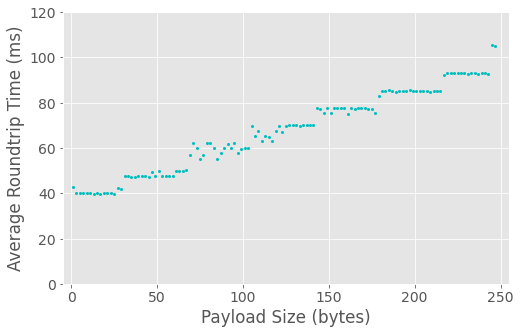

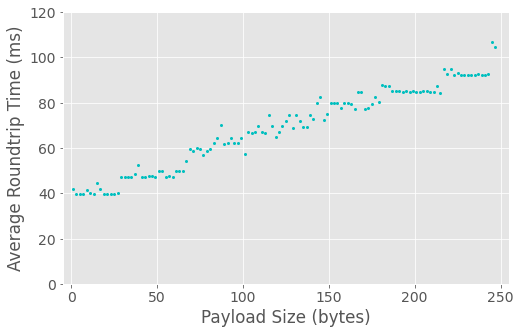

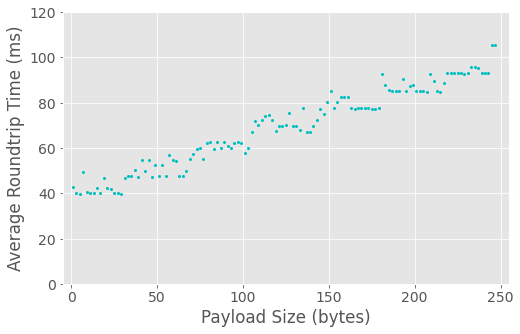

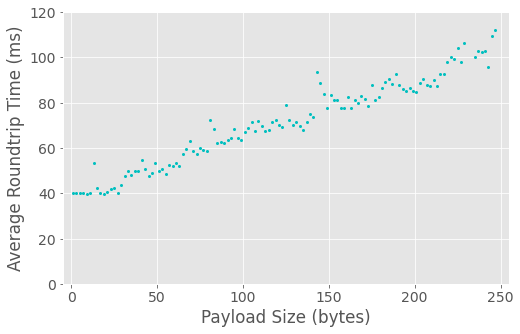

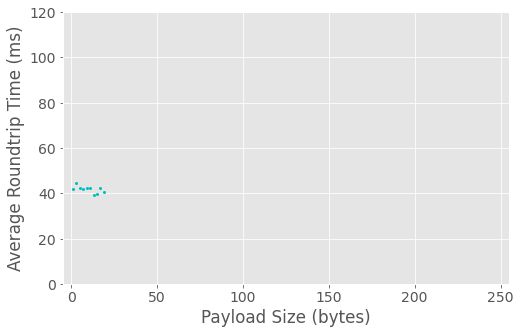

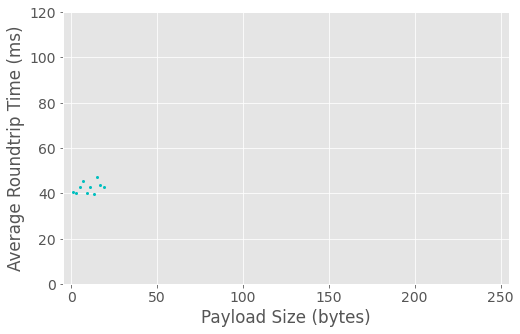

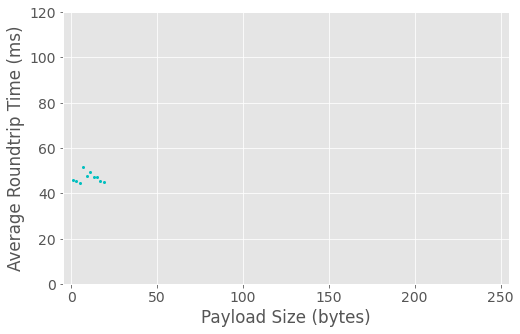

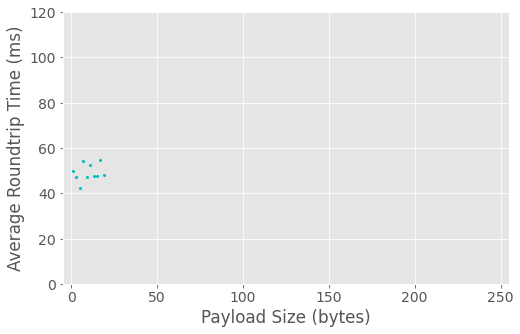

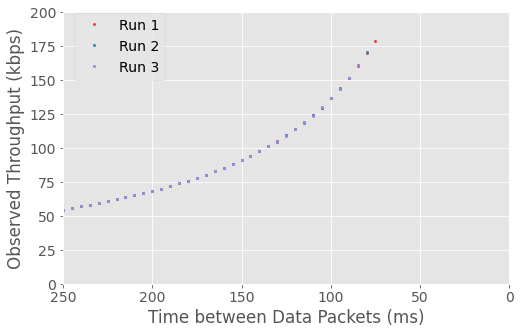

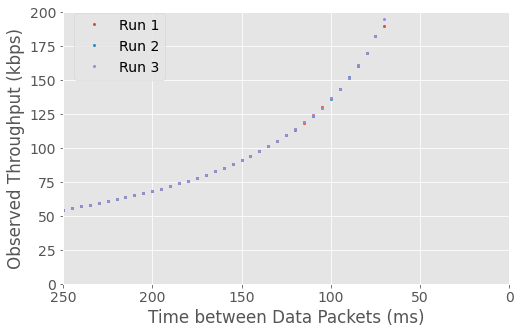

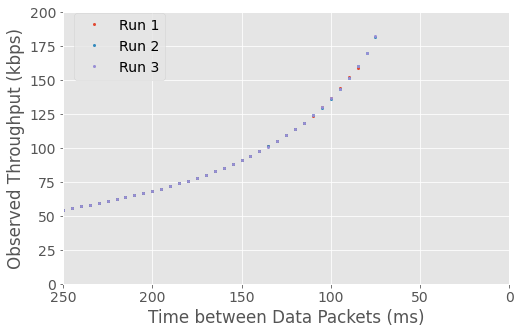

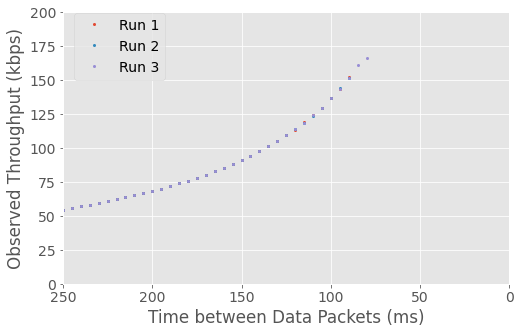

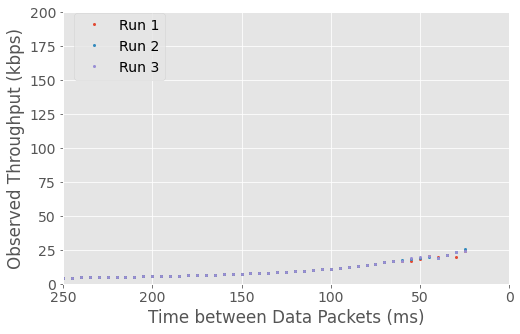

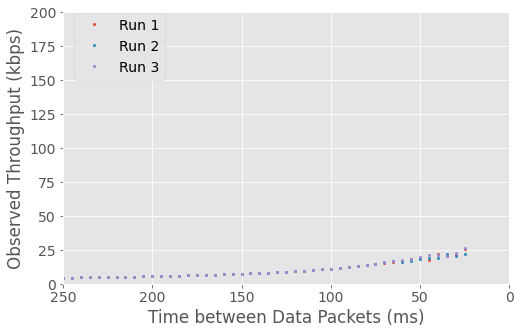

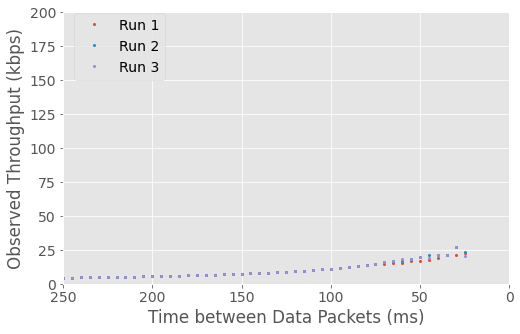

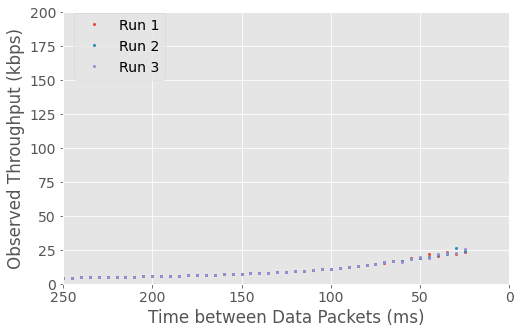

In [69]:

roundtriptest_results = pd.DataFrame()
bwtest_finalresults = pd.DataFrame()

plt.rcParams.update({'font.size': 14})

#tests = ['roundtrip',]
for test in tests:
    for adapter in adapters:
        for distance in distances:
            for phy in phyTypes:
                if test == "roundtrip":
                    data = roundtrip_tests[(roundtrip_tests[adapter_header] == adapter) & (roundtrip_tests[distance_header] == distance) & (roundtrip_tests[physicalLayer_header] == phy)]
                    
                    roundtripTimes = []
                    payloadSizes = []
                    fig = plt.figure(figsize=[8,5])#(figsize=[8,8])
                    axis = fig.add_subplot()
                    #axis.set_title(r"Roundtrip - {}cm".format(distance))

                    #fig1 = plt.figure()#(figsize=[8,8])
                    #axis1 = fig1.add_subplot()
                    #axis1.set_title(r"Bandwidth - {}cm".format(distance))
                    for payloadSize in data[payloadSize_header]:
                        #TODO: change this to the correct method
                        roundtripTime = data[data[payloadSize_header] == payloadSize][roundtripTime_header].to_numpy()[0]

                        if (len(roundtripTimes) == 0):
                            roundtripTimes.append(roundtripTime)
                            payloadSizes.append(payloadSize)
                        
                        # 6ms difference, I initially used the 7.5 ms connection interval, but this seems to fit better to the results
                        elif (abs(np.average(roundtripTimes) - roundtripTime - np.std(roundtripTimes)) > 0.0075):
                            #axis1.plot(payloadSizes, 7*8*np.array(payloadSizes)/(1000*np.array(roundtripTimes)), 'o')
                            axis.plot(payloadSizes, 1000*np.array(roundtripTimes), 'oc', markersize=2)
                            roundtriptest_currentresult = {}
                            roundtriptest_currentresult["First Payload Size (bytes)"] = payloadSizes[0]
                            roundtriptest_currentresult["Max Payload Size (bytes)"] = payloadSizes[-1]       
                            roundtriptest_currentresult["Payload Size Diff (bytes)"] = (payloadSizes[-1] - payloadSizes[0]) + 1
                            roundtriptest_currentresult["Average Roundtrip Time (s)"] = np.average(roundtripTimes)
                            roundtriptest_currentresult["Standard Dev Roundtrip Time"] = np.std(roundtripTimes)
                            roundtriptest_currentresult[physicalLayer_header] = phy
                            roundtriptest_currentresult[distance_header] = distance
                            roundtriptest_currentresult[adapter_header] = adapter


                            roundtriptest_results = roundtriptest_results.append(pd.DataFrame([roundtriptest_currentresult]), ignore_index=True)

                            # reset buffers
                            roundtripTimes = [roundtripTime,]
                            payloadSizes = [payloadSize,]
                        else:
                            roundtripTimes.append(roundtripTime)
                            payloadSizes.append(payloadSize)

                    if (len(payloadSizes) > 1):
                        #axis1.plot(payloadSizes, 7*8*np.array(payloadSizes)/(1000*np.array(roundtripTimes)), 'o')
                        axis.plot(payloadSizes, 1000*np.array(roundtripTimes), 'oc', markersize=2)

                    axis.set_xlabel(r'Payload Size (bytes)')
                    axis.set_ylabel(r'Average Roundtrip Time (ms)')
                    #axis.xaxis.label.set_fontsize(20)
                    #axis.yaxis.label.set_fontsize(20)

                    #axis.set_title("Distance: {}m".format(int(distance/100)))
                    #axis1.set_xlabel(r'Payload Size (bytes)')
                    #axis1.set_ylabel(r'Minimum Estimated Bandwidth (kbps)')
                    axis.set_ylim(0, 120)
                    axis.set_xlim(-5, 255)
                    fig.savefig(r"ble-roundtrip-{}-{}cm.pdf".format(adapter, distance))
                    #fig1.savefig(r"ble-pseudo-bandwidth-{}cm.pdf".format(distance))
                if test == "bandwidth":
                    data_allruns = bandwidthtest_results[(bandwidthtest_results[adapter_header] == adapter) & (bandwidthtest_results[distance_header] == distance)]

                    payloadSize = data_allruns[payloadSize_header].mean()
                    testruns = data_allruns[bandwidthTestRunIndex_header].unique()

                    fig = plt.figure(figsize=[8,5])#(figsize=[8,8])
                    axis = fig.add_subplot()
                    for testRunIndex in testruns:

                        plotdata = bandwidthtest_results[(bandwidthtest_results[adapter_header] == adapter) &   
                        (bandwidthtest_results[distance_header] == distance) &
                        (bandwidthtest_results[bandwidthTestRunIndex_header] == testRunIndex)]

                        tempdata = plotdata.copy()
                        tempdata['test'] =((100-tempdata[packetLoss_header]).divide(plotdata[expectedTimeBetweenPackets_header], axis=0, fill_value = None)).mul(payloadSize*10*8*7/1000)

                        maxbwval = tempdata[tempdata['test']==tempdata['test'].max()]

                        print("dist:{}, adap:{}) bandwidth {}bps, time between packets {} (->{}) ms, packet loss {} %".format(distance, adapter, round_num(float(maxbwval['test'])), float(maxbwval[expectedTimeBetweenPackets_header]), round_num(round_num(float(maxbwval[observedTimeBetweenPackets_header]))), round_num(float(maxbwval[packetLoss_header]))))

                        bwtest_finalresults = bwtest_finalresults.append(maxbwval, ignore_index=True)

                        #print(plotdata[expectedTimeBetweenPackets_header])
                        axis.plot(plotdata[expectedTimeBetweenPackets_header], tempdata['test'], 'o', markersize=2, label='Run {}'.format(testRunIndex))

                        #axis.plot(plotdata[expectedTimeBetweenPackets_header], plotdata[packetLoss_header], 'o', markersize=2, label='Run {}'.format(testRunIndex))
                        #print("(adapter: {}, d:{}, pd:{}) Min value: {} ms Max Bandwidth: {} bps, Packet Loss {}%".format(adapter, distance, payloadSize, plotdata[expectedTimeBetweenPackets_header].min(), ((100-plotdata[packetLoss_header]).divide(plotdata[expectedTimeBetweenPackets_header], axis=0, fill_value = None)).mul(payloadSize*10*8*7).max(), plotdata[packetLoss_header]))


                        

                        #axis.plot(plotdata[expectedTimeBetweenPackets_header], 100-(plotdata[expectedTimeBetweenPackets_header] / plotdata[observedTimeBetweenPackets_header]).clip(upper=1)*100, 'o', markersize=2, label='Run {}'.format(testRunIndex))
                        #axis.set_ylim(-0.3, 5)
                        #axis.set_xlim(plotdata[expectedTimeBetweenPackets_header].min() - 50, plotdata[expectedTimeBetweenPackets_header].max() +50)
                    #axis.set_xlabel(r'Transmission Frequency (Hz)')
                    axis.set_xlabel(r'Time between Data Packets (ms)')
                    axis.set_ylim(0, 200)
                    if (adapter == 'hci0'):
                        axis.set_xlim(0, 250)
                        #axis.set_ylim(-0.4, 5)
                    else:
                        axis.set_xlim(0, 250)
                        #axis.set_ylim(-2, 50)
                    axis.invert_xaxis()
                    #axis.invert_yaxis()

                    #axis.xaxis.label.set_fontsize(20)
                    #axis.yaxis.label.set_fontsize(20)
                    #axis.set_ylabel(r'Packet Loss (%)')
                    axis.set_ylabel(r'Observed Throughput (kbps)')

                    #axis.set_title("Distance: {}m".format(int(distance/100)))
                    axis.legend(loc=(0.75, 0.75))
                    fig.savefig(r"ble-bandwidth-{}-{}cm.pdf".format(adapter, distance))


#print(roundtriptest_results)

In [54]:
for adapter in adapters:
    for distance in distances:
        data = maxbwval[(maxbwval[distance_header]==distance) & (maxbwval[adapter_header]==adapter)]
        print(maxbwval)
        print("dist:{}, adap:{}) bandwidth {}(+-{})bps, ".format(distance, adapter, float(data['test'].mean()), float(data['test'].std())))

     Adapter Distance (cm)  Observed Time Std between packets (ms)  \
2023    hci1           900                               14.034126   

      Observed Time between packets (ms)  Packet Loss (%)  \
2023                           48.158352        43.452987   

      Payload Size (bytes) Run Index Time between packets (ms)          test  
2023                  20.0         3                        25  25333.061603  
dist:0, adap:hci0) bandwidth nan(+-nan)bps, 
     Adapter Distance (cm)  Observed Time Std between packets (ms)  \
2023    hci1           900                               14.034126   

      Observed Time between packets (ms)  Packet Loss (%)  \
2023                           48.158352        43.452987   

      Payload Size (bytes) Run Index Time between packets (ms)          test  
2023                  20.0         3                        25  25333.061603  
dist:300, adap:hci0) bandwidth nan(+-nan)bps, 
     Adapter Distance (cm)  Observed Time Std between packets (m

In [9]:

# analyse roundtrip results
#data = roundtriptest_results[roundtriptest_results[distance_header] == 0]
#data.drop(0, inplace=True)
#print(roundtriptest_results)

for distance in distances:
    data = roundtriptest_results[roundtriptest_results[distance_header] == distance].reset_index()
    data.drop(0, inplace=True)
    print("Payload Size Diff: {} +- {}".format(np.average(data["Payload Size Diff (bytes)"]), np.std(data["Payload Size Diff (bytes)"])))
    print("Average Roundtrip Time Diff (ms): {} +- {}".format(1000*np.average(data["Average Roundtrip Time (s)"].diff().dropna()), 1000*np.std(data["Average Roundtrip Time (s)"].diff().dropna())))


Payload Size Diff: 34.666666666666664 +- 3.5433819375782165
Average Roundtrip Time Diff (ms): 8.945516541353388 +- 1.2190843592229361
Payload Size Diff: 18.636363636363637 +- 11.178491744683198
Average Roundtrip Time Diff (ms): 4.4135411904761925 +- 4.746441039534993
Payload Size Diff: 16.0 +- 10.737118528064887
Average Roundtrip Time Diff (ms): 3.3982327416173588 +- 5.660537406594012
Payload Size Diff: 13.588235294117647 +- 10.622167849690083
Average Roundtrip Time Diff (ms): -0.22003958333333345 +- 33.55065150708985


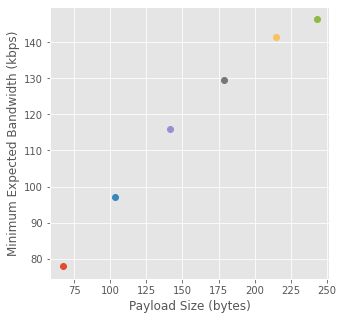

In [10]:

fig = plt.figure(figsize=[5,5])
axis = fig.add_subplot()

data = roundtriptest_results[roundtriptest_results[distance_header] == 0].reset_index()
data.drop(0, inplace=True)

for idx in data.index:
    row = data.loc[idx]
    bandwidth_avg = (row["Max Payload Size (bytes)"] / (1000*row["Average Roundtrip Time (s)"]))*7*8
    axis.set_xlabel(r'Payload Size (bytes)')
    axis.set_ylabel(r'Minimum Expected Bandwidth (kbps)')
    axis.plot(row["Max Payload Size (bytes)"], bandwidth_avg, 'o')